# Test `fit_nonlinear_coloring_trajectory_bijector`

In [1]:
%run init.ipy

from lib import aplawd
from lib import praat
from dgf import bijectors
from dgf import isokernels
from dgf import core
from dgf import constants
from dgf.prior import period

import dynesty
import pandas as pd
import warnings
import itertools
import scipy.stats
import multiprocessing

import random
import itertools

## Period

In [2]:
data = period.get_aplawd_training_pairs()

[Memory]2.9s, 0.0min    : Loading get_aplawd_training_pairs...


In [3]:
pplen = [len(d[0]) for d in data]
np.quantile(pplen, .9868)

100.0

In [4]:
np.quantile(pplen, .99)

108.48999999999978

In [5]:
subset = period.get_aplawd_training_pairs_subset()
samples = [d[0][:,None] for d in subset]

bounds = jnp.array([
    constants.MIN_PERIOD_LENGTH_MSEC,
    constants.MAX_PERIOD_LENGTH_MSEC
])[None,:]

[Memory]4.2s, 0.1min    : Loading get_aplawd_training_pairs...


We select a subset 5000 samples with an arbitrary max period length of 100 (= .9868 quantile) to ease fitting. Since we are doing max likelihood and the posterior is so peaked anyway, this really is inconsequential.

Fitting takes 10 hrs without the jit speedup we are still waiting for.

We find the lengthscale to be markedly bigger (30 instead of 10 for Matern3
2Kernel) than with our previous approach, which is pleasing, because this sounds much more realistic.
(Note: the lengthscale is safely below 100, so we didn't interfere with our subset).

This difference is probably due to the fact that our new way of fitting the bijector deals with outliers (close to 2 and 20 msec) much better and that the marginal variance is also larger.

**Note: prior: our lognormal prior should really be base $10$, not base $e$; this gives a much better dynamic range which is expected a priori. This will lead to faster nested sampling.**

Given $Z \sim N(0,1)$, then our lognormal variable is 
$$X = 10^{\mu+\sigma Z} = e^{\log{10}(\mu+\sigma Z)}$$ so use regular lognormal with both $\mu$ and $\sigma$ scaled by $\log 10$.

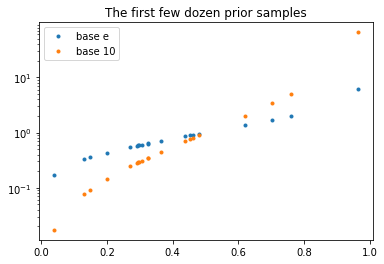

In [6]:
from scipy.stats import lognorm

lognorm_e  = lognorm(1.)
lognorm_10 = lognorm(np.log(10))

# We want our first few draws to scan out a realistic range
u= sorted(rand(20))

plot(u,lognorm_e.ppf(u), '.', label='base e')
plot(u,lognorm_10.ppf(u), '.', label='base 10')
yscale('log')
title('The first few dozen prior samples')
legend();

In [7]:
# cacheid with the good run: cacheid=34180
results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    samples, bounds, "Matern32Kernel", 34180
)

results

[Memory]20.4s, 0.3min   : Loading run_nested...


       nlive: 15
       niter: 417
       ncall: array([  1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   3,   6,   1,
         1,   2,   1,   4,   5,   1,   2,   4,   6,   1,   1,   2,   1,
         4,  12,   6,   8,   1,   2,  12,   6,  10,   3,  31,  19,  15,
        27,   6,   6,  16,  16,  53,   7, 120,   7,  48,   3,  50,  13,
        45,   4,   2,   7,  11,   9,  47,  19,  27,   2,   6,  19,  15,
         7,  42,   5,   2,   1,   1,   2,  24,   4,   9,  16,   4,   2,
        23,   2,   5,  13,   3,   3,   2,  13,   6,   3,   6,  20,  15,
        17,  10,   5,  12,  13,  22,   1,   2,   2,   1,  42,  19,   9,
         4,   2,  10,   1,  26,   2,   1,  20,   9,  13,   1,   3,   2,
         9,   1,   1,   6,   3,   2,   5,   5,   2,   1,   1,   3,   1,
         7,   2,   3,   1,   1,   5,   1,   4,  11,   4,   9,   1,   2,
         1,  12,   1,   1,   8,   1,   1,   3,   1,   1,   2,   8,   3,
         2,  48,  26,  14,  37,  10,   1,   4,   1,   1,   3,   2,   8,
        14,   2

Summary
nlive: 15
niter: 417
ncall: 4055
eff(%): 10.654
logz: -90214.531 +/-  1.209


None

'Information (bans)'

9.446158372781893

Quantiles:
s [(0.025, 1.42666281421959), (0.5, 1.4476510879290045), (0.975, 1.4731845529437297)]
Quantiles:
envelope_lengthscale [(0.025, 28.27546960512073), (0.5, 28.705140932593842), (0.975, 29.169434972646698)]
Quantiles:
envelope_noise_sigma [(0.025, 0.09344378722568149), (0.5, 0.0950754936188292), (0.975, 0.09691534209337799)]


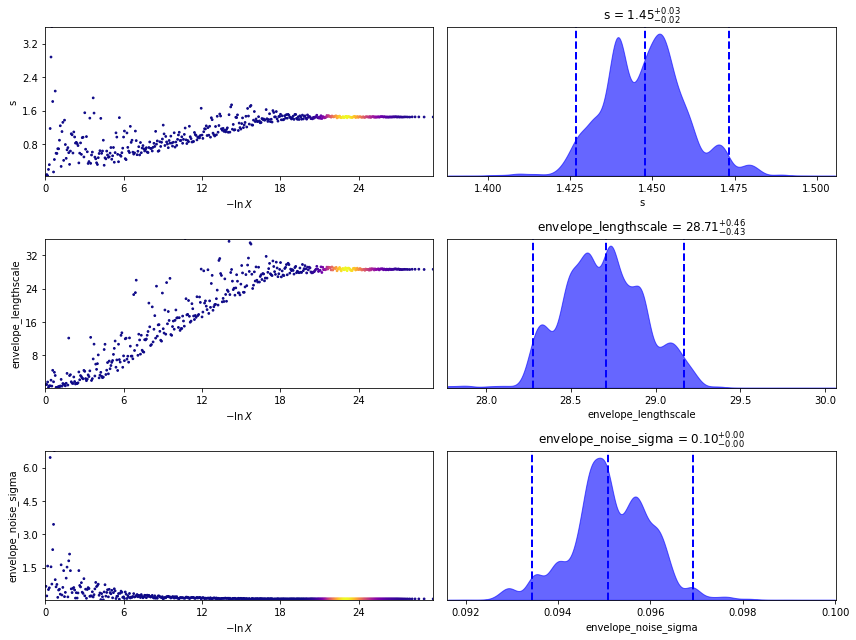

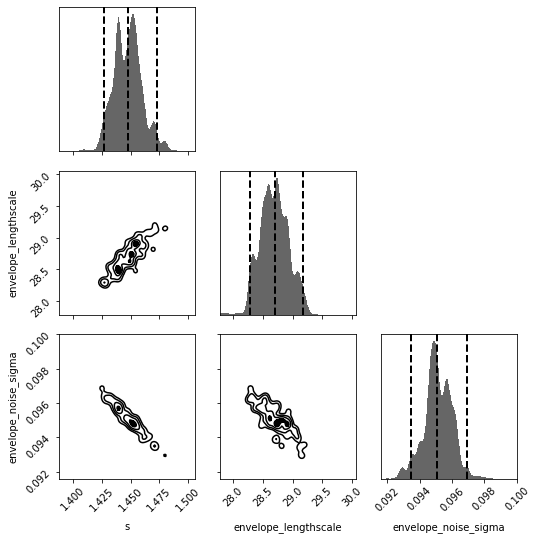

In [8]:
from dynesty import plotting

display(results.summary())
display('Information (bans)', results.information[-1] * log10(e))

VARIABLE_NAMES = ['s', 'envelope_lengthscale', 'envelope_noise_sigma']
fig, axes = dynesty.plotting.traceplot(
    results, show_titles=True,
    labels=VARIABLE_NAMES,
    verbose=True
)
tight_layout()

fg, ax = dynesty.plotting.cornerplot(results, labels=VARIABLE_NAMES)
tight_layout()
show()

In [9]:
results.samples[-1]

array([ 1.44639826, 28.64557624,  0.09519052])

In [10]:
bijectors.get_log_stats(jnp.vstack(samples), bounds)

{'samples': DeviceArray([[1.75785792],
              [1.85629799],
              [1.84845481],
              ...,
              [2.45958884],
              [2.4765384 ],
              [2.50143595]], dtype=float64),
 'bounds': DeviceArray([[0.69314718, 2.99573227]], dtype=float64),
 'mean': DeviceArray([1.93108163], dtype=float64),
 'cov': DeviceArray([[0.091735]], dtype=float64),
 'sigma': DeviceArray([0.30287786], dtype=float64),
 'corr': DeviceArray([[1.]], dtype=float64),
 'L_corr': DeviceArray([[1.]], dtype=float64)}

## Formants

In [11]:
from lib import htkio

formant_data, frate, feakind = htkio.htkread("dgf/test/si1149.fb")

formants = formant_data[:3,:].T

m, n = formants.shape

formants # kHz

array([[0.60038465, 1.54463804, 2.50881076],
       [0.64932722, 1.5456332 , 2.52436972],
       [0.66138232, 1.47878063, 2.59593034],
       ...,
       [0.62746179, 1.38237345, 2.71759462],
       [0.54841679, 1.44805717, 2.46356225],
       [0.57549101, 1.45660532, 2.39775181]])

In [12]:
samples2 = [formants]

bounds2 = jnp.array([[0.2, 5.]]*n)

bounds2

DeviceArray([[0.2, 5. ],
             [0.2, 5. ],
             [0.2, 5. ]], dtype=float64)

In [13]:
bijectors.get_log_stats(jnp.vstack(samples2), bounds2)

{'samples': DeviceArray([[-0.51018474,  0.4347896 ,  0.91980884],
              [-0.4318185 ,  0.43543366,  0.92599141],
              [-0.41342321,  0.39121785,  0.95394496],
              ...,
              [-0.4660725 ,  0.32380191,  0.99974716],
              [-0.60071971,  0.37022278,  0.90160837],
              [-0.55253167,  0.3761086 ,  0.87453155]], dtype=float64),
 'bounds': DeviceArray([[-1.60943791,  1.60943791],
              [-1.60943791,  1.60943791],
              [-1.60943791,  1.60943791]], dtype=float64),
 'mean': DeviceArray([-0.56844475,  0.5527555 ,  0.97001096], dtype=float64),
 'cov': DeviceArray([[0.06484969, 0.00184748, 0.00543795],
              [0.00184748, 0.04186332, 0.00686327],
              [0.00543795, 0.00686327, 0.00755033]], dtype=float64),
 'sigma': DeviceArray([0.25465603, 0.20460529, 0.08689263], dtype=float64),
 'corr': DeviceArray([[1.        , 0.03545753, 0.24575279],
              [0.03545753, 1.        , 0.38603929],
              [0.2457527

**Memory leak, probably in Transpose**

Will probably be fixed by jit compiling

Other memory leaks:

https://github.com/tensorflow/probability/issues/493

https://github.com/tensorflow/probability/issues/647

In [14]:
# n = 1: cacheid=19278 (still has memory leak)
results2 = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    samples2, bounds2, "Matern32Kernel", 19278
)

results2

[Memory]24.9s, 0.4min   : Loading run_nested...


       nlive: 15
       niter: 258
       ncall: array([ 1,  1,  1,  1,  1,  1,  2,  1,  1,  2,  2,  5,  2,  3,  1,  4,  1,
        6,  2,  2,  1,  4,  4,  2,  6,  3,  3,  1,  1,  7, 19,  4,  5, 17,
        3,  9, 12,  2, 25, 17, 27,  8, 14, 31, 35, 12, 29,  3, 78, 14, 10,
       34, 52,  7, 23,  7, 11, 11,  1,  1,  6,  6,  1,  5,  1,  5,  6, 16,
       23,  3,  4,  2,  3,  4,  2,  2, 16, 11,  1,  4,  3,  9, 17,  3, 13,
       91,  2,  6,  1, 50,  4,  4,  5, 32, 28, 15, 12,  8,  6, 27,  1,  5,
        2,  1,  3, 11,  9,  6, 36,  2,  3,  7,  1,  2,  3,  3,  8,  1,  3,
        1,  7, 19,  4,  2,  8,  4, 26,  3,  3,  8, 20,  8, 14,  5,  8,  8,
        6,  1,  6, 19,  4, 18,  2,  6, 50,  3,  5,  2, 11,  6,  4,  1,  6,
       22, 11,  1,  3,  8,  1,  1,  4,  4,  1,  2,  1,  3,  8, 21,  9, 27,
       15,  3,  1,  6,  1, 46,  3,  2,  2,  5,  1,  4, 12, 11,  1, 24,  1,
        8,  5, 13,  1,  7,  1,  8,  5, 45,  2,  1,  1,  1,  2,  2,  4,  1,
        4,  2,  5,  1,  2,  1,  1,  3,  9,  1,  5, 

Summary
nlive: 15
niter: 258
ncall: 2161
eff(%): 12.633
logz: 734.791 +/-  0.885


None

'Information (bans)'

5.0542825049518765

Quantiles:
s [(0.025, 0.8334350986775172), (0.5, 1.0259410082427258), (0.975, 1.2738035830681522)]
Quantiles:
s [(0.025, 5.487883414804426), (0.5, 6.657321174513087), (0.975, 8.107807264920496)]
Quantiles:
s [(0.025, 0.05058585145425218), (0.5, 0.06749815251061214), (0.975, 0.08903682754470141)]


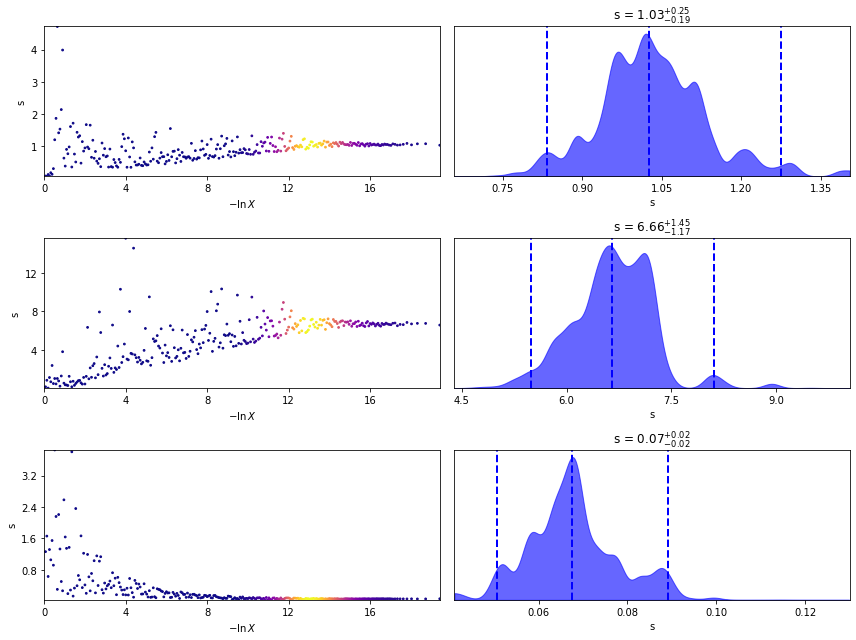

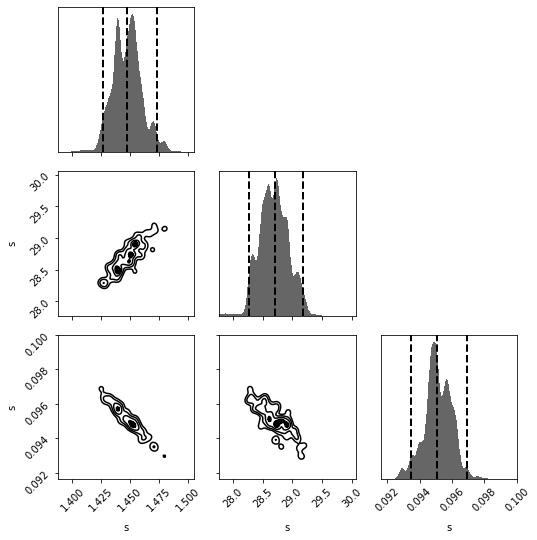

In [15]:
from dynesty import plotting

display(results2.summary())
display('Information (bans)', results2.information[-1] * log10(e))

VARIABLE_NAMES = [*(['s']*n), 'envelope_lengthscale', 'envelope_noise_sigma']
fig, axes = dynesty.plotting.traceplot(
    results2, show_titles=True,
    labels=VARIABLE_NAMES,
    verbose=True
)
tight_layout()

fg, ax = dynesty.plotting.cornerplot(results, labels=VARIABLE_NAMES)
tight_layout()
show()